In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io as scp
import copy
import random
from sklearn.model_selection import StratifiedKFold
import scipy
import math
import pickle

from sklearn.linear_model import LinearRegression

#Machine learning libraries 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
import sklearn as skl
from sklearn.model_selection import train_test_split
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

C:\Users\Yassine\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def Normalize_Vectors(Matrix, Min, Max):

    Normalized_Matrix = np.zeros(Matrix.shape)
    for i in range(Matrix.shape[0]):
        for j in range(Matrix.shape[1]):
            Normalized_Matrix[i,j] = (Matrix[i,j]-Min)/(Max-Min)
    return Normalized_Matrix

def Vectorize_Connectivity_Matrix(Original_Matrix):
    N_Subjects = Original_Matrix.shape[2]
    N_Brain_Regions = 90
    #Lower Triangle n_elements --> (90*90/2) - 90/2 = 4005
    N_Elements_In_Vector = 4005 

    Vectorized_Matrix = np.zeros((N_Subjects, N_Elements_In_Vector)) 
  
    for n in range(N_Subjects):
        Counter = 0
        for i in range(N_Brain_Regions):
            for j in range(N_Brain_Regions):
                if i>j:
                    Vectorized_Matrix[n, Counter] = Original_Matrix[i,j,n]
                    Counter +=1
                  
    return Vectorized_Matrix

def flatten_list(list_):
    new_list = []
    for i in list_:
        for j in i:
            new_list.append(j)
    return new_list

def Get_Mean_Absolute_Error(ytest, ypred):
    MAE_ = np.zeros(len(ytest), )

    for i in range(len(ytest)):
        MAE_[i] = np.abs(ytest[i]-ypred[i])
    return np.mean(MAE_)

def Performance_Scores(ytest_5folds, ypredicted_5folds):
    
    for i in range(len(ytest_5folds)):
        MAE_fold = Get_Mean_Absolute_Error(ytest_5folds[i], ypredicted_5folds[i])
        Corr_fold = scipy.stats.pearsonr(np.array(ytest_5folds[i]).flatten(), np.array(ypredicted_5folds[i]).flatten())
        MAD_Fold = scipy.stats.median_absolute_deviation(np.array(ypredicted_5folds[i]).flatten()) #Mean Absolute deviation
        R2_Fold = skl.metrics.r2_score(np.array(ytest_5folds[i]).flatten(), np.array(ypredicted_5folds[i]).flatten())
        print('For fold', str(i+1), '--- MAE =', MAE_fold, '--- Corr =', Corr_fold[0], '--- p value =',Corr_fold[1], '--- MAD of prediction:', MAD_Fold, '--- R2: ', R2_Fold)

    ytest_flat = []
    ypred_flat = []
    for i in range(len(ytest_5folds)):
        for j in range(len(ytest_5folds[i])):
            ytest_flat.append(ytest_5folds[i][j])
            ypred_flat.append(ypredicted_5folds[i][j])

    Total_MAE = Get_Mean_Absolute_Error(ytest_flat, ypred_flat)
    Total_Corr = scipy.stats.pearsonr(np.array(ytest_flat).flatten(), np.array(ypred_flat).flatten())
    Total_MAD = scipy.stats.median_absolute_deviation(np.array(ypred_flat).flatten()) #Mean Absolute deviation
    Total_R2 = skl.metrics.r2_score(np.array(ytest_flat).flatten(), np.array(ypred_flat).flatten())


    print('For total scores, MAE =', Total_MAE, '--- Corr =', Total_Corr[0], '--- p value =',Total_Corr[1], '--- MAD of prediction:', Total_MAD, '--- R2: ', Total_R2)


# Load data and preprocessing

In [3]:
#Load data from matlab struct - turn into np array, and verify shape is correct

Path_to_Connectivity = os.path.abspath('C:/Users/Yassine/Documents/3rd Year Project/Summer Work/Code/NewStructuralConnectivity.mat')
Data = scp.loadmat(Path_to_Connectivity)

PMA = np.array(Data.get('pma'))
GA = np.array(Data.get('ga'))
Sex = np.transpose(np.array(Data.get('sex')))
Structural = np.array(Data.get('SCmu'))
N = Structural.shape[2]
Names = Data.get('sub')
Subject_ID = [x.tolist()[0][4:] for x in Names[0]]

print('Shape of sex : ' , Sex.shape)
print('Shape of GA : ' , GA.shape)
print('Shape of PMA : ', PMA.shape)
print('Shape of Structural Matrix : ', Structural.shape)

Shape of sex :  (1, 524)
Shape of GA :  (524, 1)
Shape of PMA :  (524, 1)
Shape of Structural Matrix :  (90, 90, 524)


## Vectorize Connectome

In [4]:
#Take lower triangle of connectivity Matrix Reshape as vector of 4005 elements
X = Vectorize_Connectivity_Matrix(Structural)

## Select preterm subjects 

In [5]:
PreTermIndex = np.array(np.where(GA<37))[0,:]
NumberOfPreTerms = PreTermIndex.shape[0]

X_PreTerm = X[PreTermIndex,:]
GA_PreTerm = GA[PreTermIndex]
PMA_PreTerm__ = PMA[PreTermIndex]

PMA_PreTerm = [] 
for i in range(len(PMA_PreTerm__)):
    PMA_PreTerm.append(float(PMA_PreTerm__[i]))

Names_PreTerm = []
for i in range(len(Subject_ID)):
    if i in PreTermIndex:
        Names_PreTerm.append(Subject_ID[i])
    else:
        continue
print('We have', len(Names_PreTerm), 'preterm subjects')

We have 106 preterm subjects


# Apply trained model to preterm cohort

In [6]:
from tensorflow.keras.models import load_model

Corrected_Predictions_PreTerm = np.zeros((NumberOfPreTerms, 5)) #5 columns for each prediction


# Normalization parameters
with open('PMA_Files/DNN/Normalization_Parameters_PMA_DNN.pkl', 'rb') as f:  
    Local_Normalization_Parameters = pickle.load(f)
    
# Bias correction parameters
with open('PMA_Files/DNN/Bias_Parameters_PMA_DNN.pkl', 'rb') as f:  
    Bias_Parameters = pickle.load(f)


# Load models and predict PMA of each preterm subject
for i in range(5):
    print(i)
#     Local_Model = keras.models.load_model(str('PMA_Prediction_Files/DNN/PMA_DNN_Model' + str(i) + '.h5'))
    Local_Model = load_model(str('PMA_Files/DNN/PMA_DNN_Model_' + str(i) + '.h5'))
    Normalized_X_Preterm = Normalize_Vectors(X_PreTerm, Local_Normalization_Parameters[i][0], Local_Normalization_Parameters[i][1])
    
    for j in range(NumberOfPreTerms):
        
        Pred = Local_Model.predict(np.transpose(Normalized_X_Preterm[j, :].reshape(-1,1)))
        Corrected_Predictions_PreTerm[j, i] = Pred + Pred*Bias_Parameters[i][0] + Bias_Parameters[i][1]
        
        

# Compute average PMA predictions of all 5 models
Predictions_Preterm = []
for i in range(NumberOfPreTerms):
    Predictions_Preterm.append(np.mean(Corrected_Predictions_PreTerm[i, :]))


0
1
2
3
4


## Visualize preterm predictions and scores

Correlation is: (0.7934827724808586, 3.6345055529512064e-24)
MAE preterm corrected: 1.0073657011830477


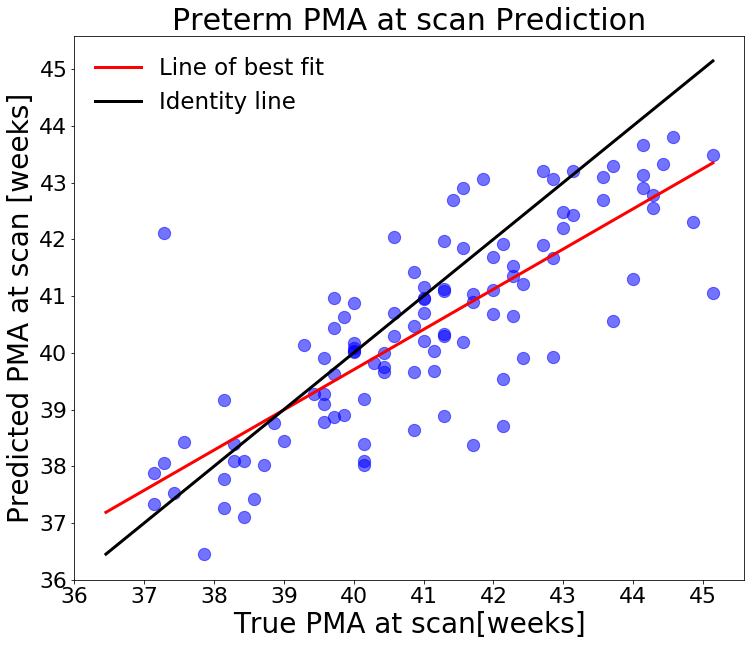

In [7]:
CORR_corrected = scipy.stats.pearsonr(list(PMA_PreTerm), list(Predictions_Preterm))
model = LinearRegression()
Model = model.fit(np.array(PMA_PreTerm).reshape(-1,1), np.array(Predictions_Preterm))
coeff = Model.coef_
intercept = Model.intercept_
print('Correlation is:', CORR_corrected)
xx = np.linspace(min(Predictions_Preterm), max(PMA_PreTerm), 5)
yy = coeff*xx + intercept

MAE_preterm_corrected = Get_Mean_Absolute_Error(np.array(PMA_PreTerm), np.array(Predictions_Preterm))
print('MAE preterm corrected:', MAE_preterm_corrected)

plt.figure(figsize = (12,10))
plt.scatter(PMA_PreTerm, Predictions_Preterm, marker = 'o', alpha = 0.55, color = 'b', s = 150)
plt.plot(xx,yy, label = 'Line of best fit', color = 'r', lw = 3)
plt.plot(xx, xx, color = 'k', label = 'Identity line', lw = 3)
title = str('Corrected Prediction: MAE:' + str(MAE_preterm_corrected) + 'Corr:' + str('  ' + str(np.round(CORR_corrected[0],2)) + '--' + str(CORR_corrected[1])))
plt.xlabel('True PMA at scan[weeks]', fontsize = 28)
plt.ylabel('Predicted PMA at scan [weeks]', fontsize = 28)
plt.legend(fontsize = 23, frameon = False)
plt.xticks([36, 37, 38, 39, 40, 41, 42, 43, 44, 45], fontsize = 22)
plt.yticks([36, 37, 38, 39, 40, 41, 42, 43, 44, 45], fontsize = 22)
plt.title('Preterm PMA at scan Prediction', fontsize = 30)
plt.savefig('Preterm_PMA_Prediction.png', dpi=250)

# Correlate residuals with outcome

## Utils function

In [8]:
def Match_OutcomeData_With_Structural_PreTerm(ytestNames, OutcomeNames, Residuals_, Outcome):

    Full_Matching = []

    Outcomes_Matched = []
    Residual_Matched = []

    for i in range(len(ytestNames)):
        if ytestNames[i] in OutcomeNames:
            Index = OutcomeNames.index(ytestNames[i])
            if math.isnan(Outcome[Index]) == 0: #Verify if outcome exists
          
                Full_Matching.append([Residuals_[i], Outcome[Index], ytestNames[i], OutcomeNames[Index]])
                Outcomes_Matched.append(Outcome[Index])
                Residual_Matched.append(Residuals_[i])
    return Full_Matching, Outcomes_Matched, Residual_Matched

def Pandas_DataFrame_to_list(pd_df, Column):
    #This is just to correctly read in CSV files
    LIST = []
    pd_df_col = pd_df[Column]
    for i in range(len(pd_df_col)):
        LIST.append(pd_df_col[i])
    return LIST


## Compute brain maturation index

Brain maturation index is here called "Residual(s)" as it presents the difference between true and predicted. This is just a naming difference. 

In [9]:
Residuals_PreTerm = []

for i in range(NumberOfPreTerms):
    #Computing predicted - true p
    Residuals_PreTerm.append(float(Predictions_Preterm[i] - PMA_PreTerm[i])) 

# Compute correlation between brain maturation index and each outcome

SPEARMAN - Model: Fine Motor ---Correlation is: 0.1045 and p value is: 0.47 N = 50
PEARSON - Model: Fine Motor ---Correlation is: 0.08254 and p value is: 0.56877 N = 50
SPEARMAN - Model: Gross Motor ---Correlation is: 0.3778 and p value is: 0.0068 N = 50
PEARSON - Model: Gross Motor ---Correlation is: 0.459 and p value is: 0.0008 N = 50
SPEARMAN - Model: Receptive ---Correlation is: 0.1478 and p value is: 0.3058 N = 50
PEARSON - Model: Receptive ---Correlation is: 0.12777 and p value is: 0.37656 N = 50
SPEARMAN - Model: Expressive ---Correlation is: 0.2854 and p value is: 0.0446 N = 50
PEARSON - Model: Expressive ---Correlation is: 0.25776 and p value is: 0.07073 N = 50
SPEARMAN - Model: Cog ---Correlation is: 0.229 and p value is: 0.1097 N = 50
PEARSON - Model: Cog ---Correlation is: 0.19863 and p value is: 0.16672 N = 50


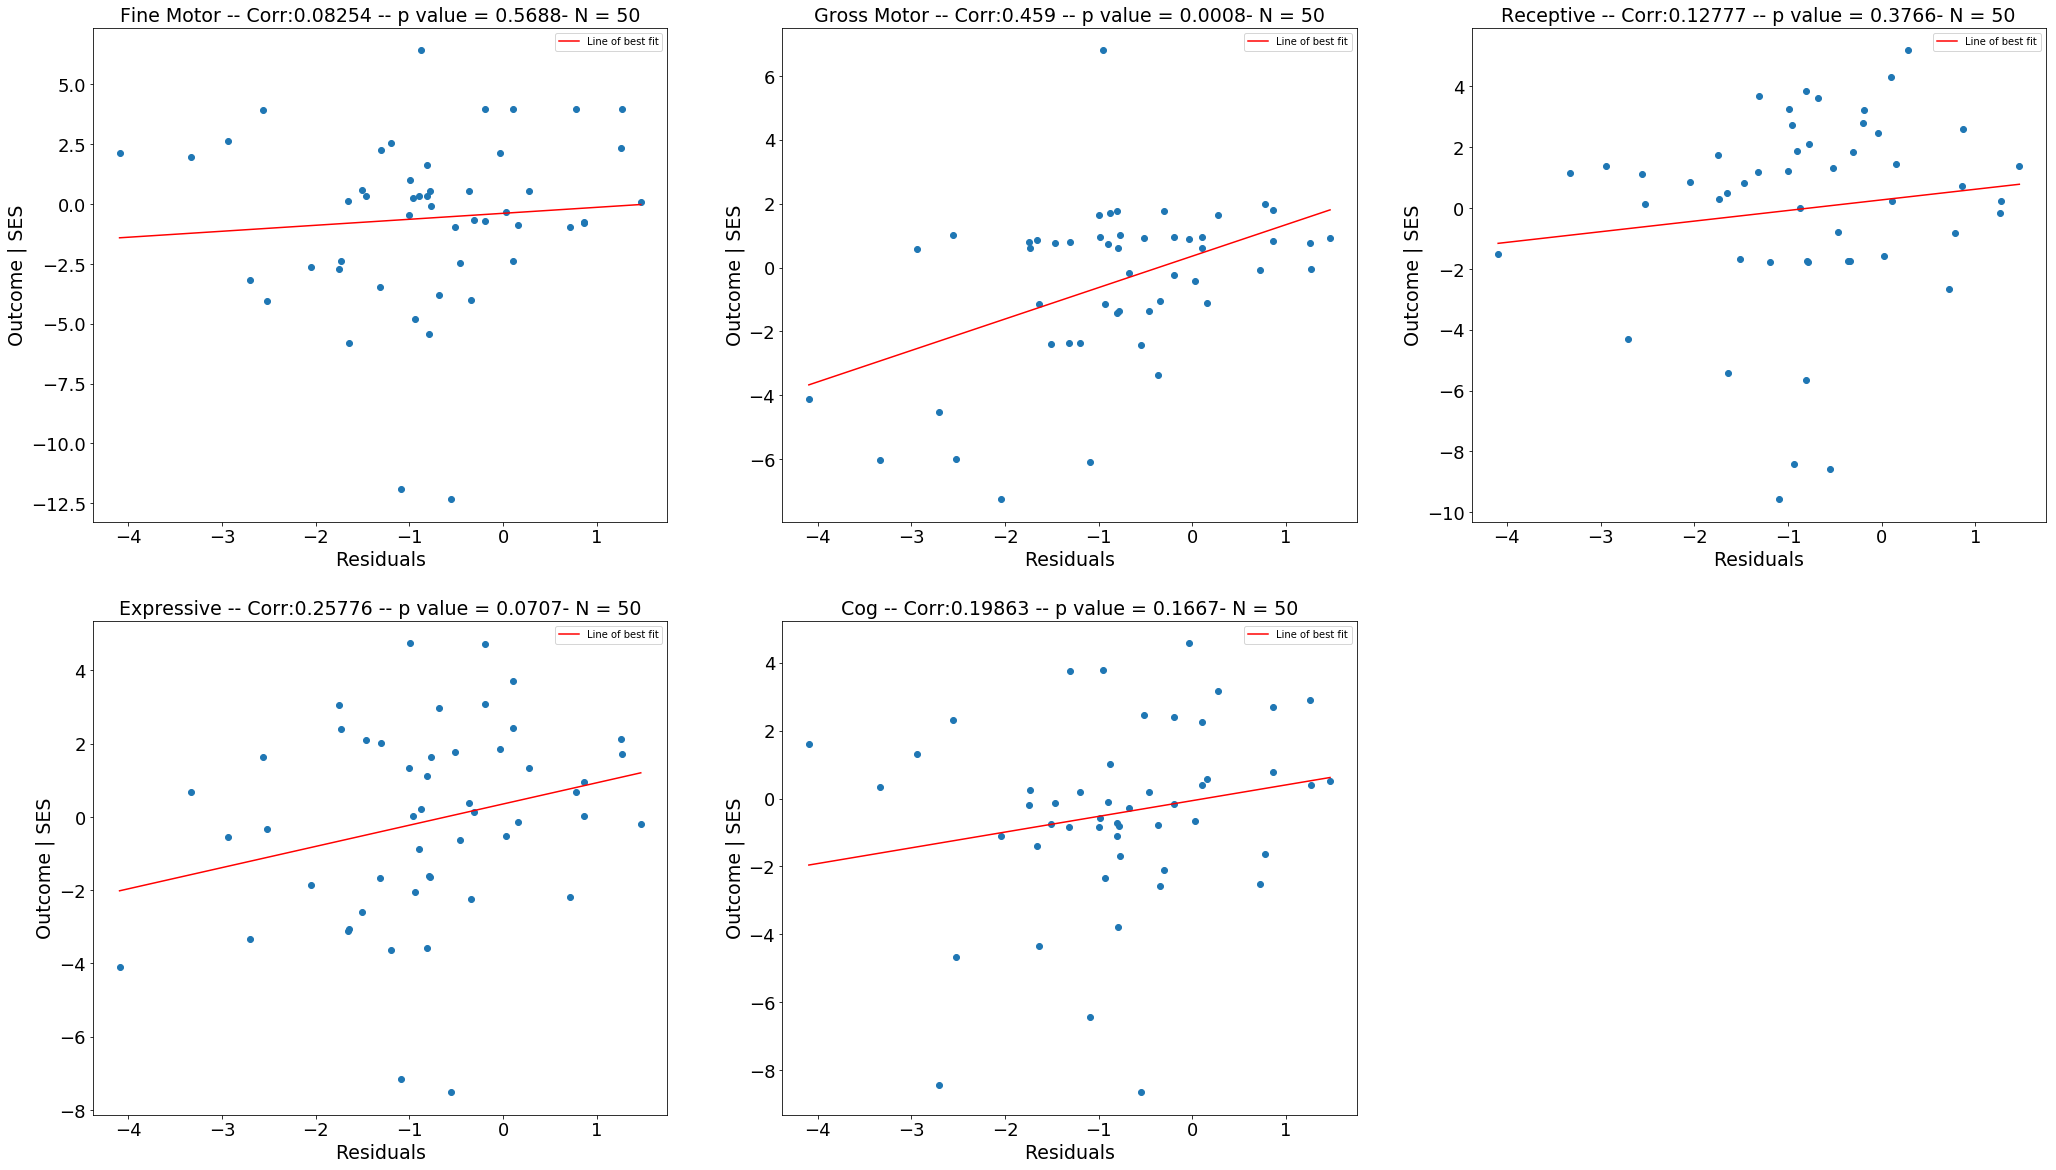

In [10]:
n = 1
plt.figure(figsize = (35,20))
Bayley_Outcomes = ['Fine Motor', 'Gross Motor', 'Receptive', 'Expressive', 'Cog']
path_to_outcomes = 'C:/Users/Yassine/Documents/3rd Year Project/Corrected Outcomes Folder/'
for Outcome in Bayley_Outcomes:
    
    File_pd = pd.read_csv(str(path_to_outcomes + Outcome + '.csv'))
    Corrected_Outcome = np.array(Pandas_DataFrame_to_list(File_pd, 'CORRECTED_OUTCOME'))
    Outcome_Names = Pandas_DataFrame_to_list(File_pd, 'SUBJECT ID')
  
    MATCHING, Outcome_Matched, Residual_Matched = Match_OutcomeData_With_Structural_PreTerm(ytestNames = Names_PreTerm, OutcomeNames = Outcome_Names,\
                                               Residuals_ = Residuals_PreTerm, Outcome = Corrected_Outcome)
    plt.subplot(2, 3, n)

    plt.scatter(Residual_Matched, Outcome_Matched) 
    plt.xlabel('Residuals', fontsize = 19)
    plt.ylabel('Outcome | SES', fontsize = 19)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)


    CORR = scipy.stats.pearsonr(Residual_Matched, Outcome_Matched)
    model = LinearRegression()
    Model = model.fit(np.array(Residual_Matched).reshape(-1,1), np.array(Outcome_Matched))
    coeff = Model.coef_
    intercept = Model.intercept_
    CORR_SPEARMAN = scipy.stats.spearmanr(Residual_Matched, Outcome_Matched)
    print('SPEARMAN - Model:', Outcome, '---Correlation is:', np.round(CORR_SPEARMAN[0], 4), 'and p value is:', np.round(CORR_SPEARMAN[1], 4), 'N =', len(Outcome_Matched))
    print('PEARSON - Model:', Outcome, '---Correlation is:', np.round(CORR[0], 5), 'and p value is:', np.round(CORR[1], 5), 'N =', len(Outcome_Matched))
    x = np.linspace(min(Residual_Matched), max(Residual_Matched), 5)
    y = coeff*x + intercept
    plt.plot(x,y, label = 'Line of best fit', color = 'r')
    title = str(Bayley_Outcomes[n-1] + ' -- Corr:' + str(str(np.round(CORR[0],5)) + ' -- p value = ' + str(np.round(CORR[1],4))) +  '- N = ' +  str(len(Outcome_Matched)))
    plt.title(title, fontsize = 19)
    n = n+1
    plt.legend()

## Visualize significant association

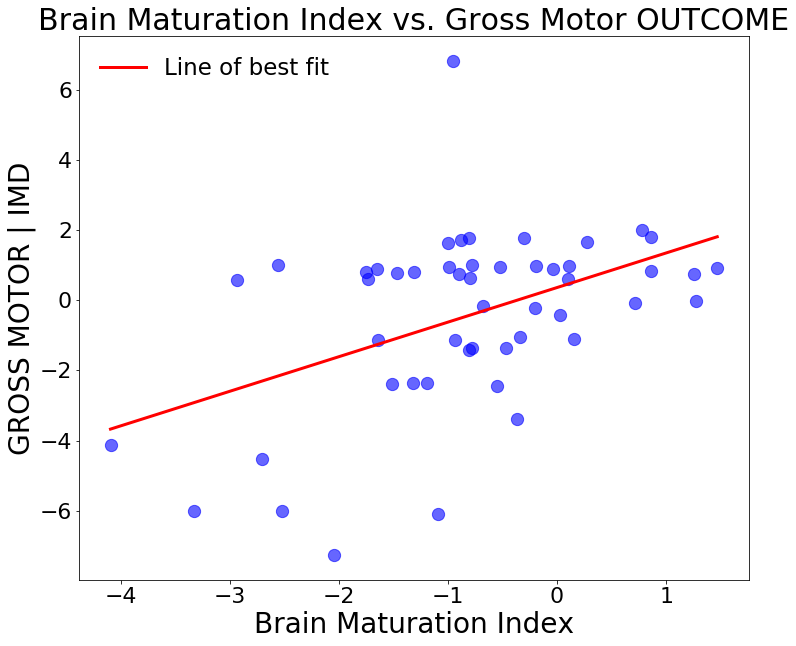

In [11]:
n = 1
plt.figure(figsize = (12,10))
Bayley_Outcomes = ['Gross Motor']
path_to_outcomes = 'C:/Users/Yassine/Documents/3rd Year Project/Corrected Outcomes Folder/'
for Outcome in Bayley_Outcomes:
    
    File_pd = pd.read_csv(str(path_to_outcomes + Outcome + '.csv'))
    Corrected_Outcome = np.array(Pandas_DataFrame_to_list(File_pd, 'CORRECTED_OUTCOME'))
    Outcome_Names = Pandas_DataFrame_to_list(File_pd, 'SUBJECT ID')
  
    MATCHING, Outcome_Matched, Residual_Matched = Match_OutcomeData_With_Structural_PreTerm(ytestNames = Names_PreTerm, OutcomeNames = Outcome_Names,\
                                               Residuals_ = Residuals_PreTerm, Outcome = Corrected_Outcome)

    

    CORR = scipy.stats.pearsonr(Residual_Matched, Outcome_Matched)
    model = LinearRegression()
    Model = model.fit(np.array(Residual_Matched).reshape(-1,1), np.array(Outcome_Matched))
    coeff = Model.coef_
    intercept = Model.intercept_
    CORR_SPEARMAN = scipy.stats.spearmanr(Residual_Matched, Outcome_Matched)
    x = np.linspace(min(Residual_Matched), max(Residual_Matched), 5)
    y = coeff*x + intercept
    
    
    plt.scatter(Residual_Matched, Outcome_Matched, marker = 'o', s = 150, alpha = 0.6, color = 'b') 
    plt.plot(x,y, label = 'Line of best fit', color = 'r', lw = 3)
    TITLE = str('Brain Maturation Index vs. ' + Bayley_Outcomes[n-1] + ' OUTCOME')
    plt.xlabel('Brain Maturation Index', fontsize = 28)
    plt.ylabel(str(str(Bayley_Outcomes[n-1]).upper() + ' | IMD'), fontsize = 28)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.legend(fontsize = 23, loc = 2, frameon = False)
    plt.title(TITLE, fontsize = 30)
    plt.savefig('Brain_Maturation_Index_Gross_Motor.png', dpi=250)
